In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

In [2]:
df = pd.read_csv("../datasets/fer2013.csv.zip")

In [3]:
df.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [4]:
df.shape

(35887, 3)

In [5]:
def split_and_scale(s):
    return np.array(s.split()).astype(np.int) / 255.0

In [6]:
df["pixels_separated"] = df.pixels.apply(lambda x:split_and_scale(x))

In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [9]:
df.head(3)

,emotion,pixels,Usage,pixels_separated
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[0.274509803922, 0.313725490196, 0.32156862745..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[0.592156862745, 0.588235294118, 0.57647058823..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[0.905882352941, 0.83137254902, 0.611764705882..."


#### label

In [10]:
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

##### 画像データの確認

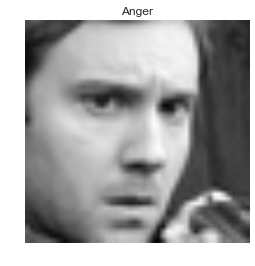

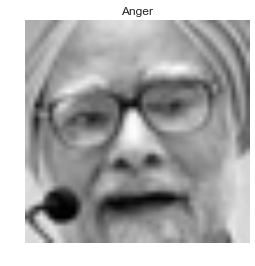

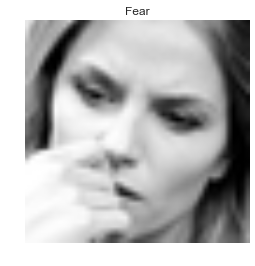

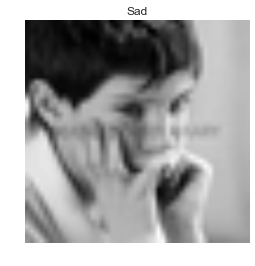

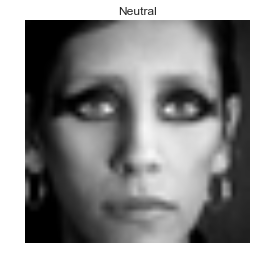

In [11]:
# 最初の5件の画像データを確認してみる
X = df.pixels_separated
y = df.emotion
for i in range(5):
    plt.imshow(X[i].reshape(48,48),cmap="gray")
    plt.title(label_map[y[i]])
    plt.axis('off')
    plt.show()

以下より、実務を意識して、データの分布の確認を行いましょう。

##### 各ラベルのデータ数の偏り

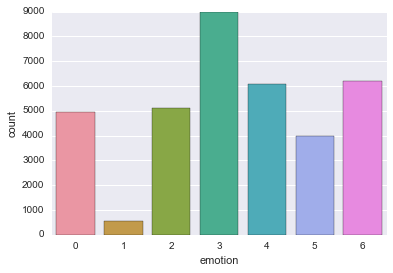

In [12]:
sns.countplot(df.emotion)

かなり偏りの大きいデータであることがわかる。特にlabel 1(Disgust)の画像データが少ない。　※これがなぜ問題なのか？質問。

##### 偏りを無くす

In [13]:
## [方針]
## label 1のものが他ラベルと比べて10分の1程度であることがわかる。
## 単純にlabel 1のデータセットを10倍にしてみる。
df_1 = df[df.emotion == 1]
df_else = df[~(df.emotion == 1)]
df_1_concat = pd.concat([df_1]*10, ignore_index=True)
df_balance = pd.concat([df_1_concat, df_else], ignore_index=True)
df_balance.shape

(40810, 4)

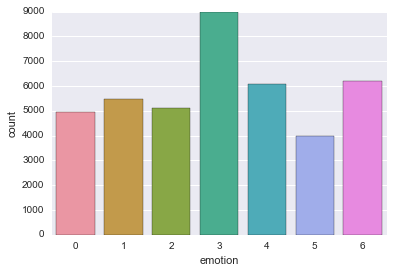

In [14]:
sns.countplot(df_balance.emotion)

good

##### データの準備

In [15]:
X = []
y = []
for lis, lb in zip(df_balance.pixels_separated, df_balance.emotion):
    X.append(lis.tolist())
    y.append(lb)
X = np.array(X)
y = np.array(y)

In [16]:
print(X.shape)
print(y.shape)

(40810, 2304)
(40810,)


In [17]:
train_idx = df_balance[df_balance.Usage == "Training"].index
test_idx = df_balance[df_balance.Usage == "PublicTest"].index

In [18]:
X_train = X[train_idx]
X_test = X[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

In [27]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

ここまで一旦前処理終了です。以下、一旦不要なものをゴミ掃除です。

In [19]:
del df
del df_1
del df_else
del df_1_concat
del df_balance
del X
del y
del train_idx
del test_idx

### NN作成 (with Keras)

下図のような5層のネットワークの構成します


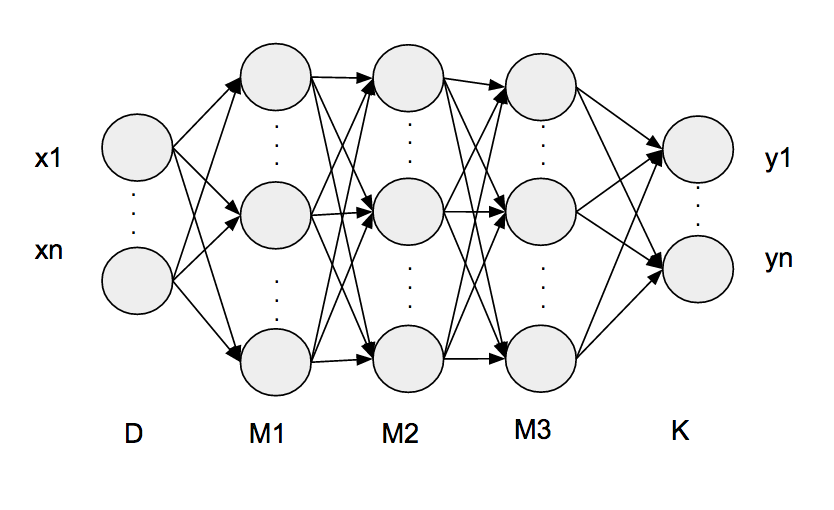

In [36]:
print("下図のような5層のネットワークの構成します")
Image(filename='../images/nn_5layer.png', width=500)

In [20]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

In [21]:
N = X_train.shape[0]
D = X_train.shape[1]
M1 = 2000
M2 = 1000
M3 = 500
K = 7

In [22]:
model = Sequential()
model.add(Dense(M1, input_shape=(D,)))
model.add(Activation("relu"))
model.add(Dense(M2))
model.add(Activation("relu"))
model.add(Dense(M3))
model.add(Activation("relu"))
model.add(Dense(K))
model.add(Activation("softmax"))
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 2000)          4610000     dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 2000)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1000)          2001000     activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 1000)          0           dense_2[0][0]                    
___________________________________________________________________________________________

In [52]:
batch_size = 1000
nb_epoch = 100
model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_data=(X_test, y_test),verbose=1, shuffle=True)

In [39]:
y_pred = model.predict(X_test)

In [46]:
y_pred_valid = np.argmax(y_pred,axis=1)

In [45]:
y_valid = np.argmax(y_test, axis=1)

In [47]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_valid, y_valid)

0.41998534082580014

正答率(accuracy) 42%をとりあえずのbench markとしましょう。

In [54]:
pd.read_csv("../datasets/fer2013.csv.zip")

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training
